In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sipp_2018 = pd.read_csv('../data/interim/sipp2018_person/sipp2018_person.csv')
sipp_2018.shape

(49704, 2127)

## Feature Engineering/Transformation

In [3]:
# collapse eeduc categories

m1 = {5:[31,32,33,34,35,36,37,38], 
      6:[39],
      7:[40,41,42],
      8:[45],
      9:[43],
      10:[44,46],
     }
m2 = {v: k for k,vv in m1.items() for v in vv}
m2
sipp_2018['EEDUC_X'] = (sipp_2018
                        .EEDUC
                        .map(m2)
                        .astype('category')
                       )
sipp_2018.EEDUC_X.value_counts()

7     14293
6     14176
9      9524
5      6000
10     4955
8       756
Name: EEDUC_X, dtype: int64

In [51]:
# Initialize Independent and Target Features 
id_cols = ['SSUID', 'PNUM', 'EOWN_ST']
stock_cols = list(sipp_2018.filter(like='STMF').columns)
asset_income = list(sipp_2018.filter(like='INC_AST').columns)
drop_cols = id_cols + stock_cols + asset_income + ['TVAL_AST'] + ['WPFINWGT'] + ['EEDUC']

# mask for any hispanic or black only or black + another race
race_mask = (sipp_2018.EORIGIN == 1) | (sipp_2018.ERACE.isin([2, 10, 11, 12, 15, 16, 19]))


y = sipp_2018[race_mask].EOWN_ST
X = sipp_2018[race_mask].drop(drop_cols, axis='columns')

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

# Univariate Selection

## Percent Missing Values
* Drop variables that have a high ratio of missing values.
* Create binary indicators to denote miss (or non-missing) values.
* Review of visualize variables with high ratio of missing values.
***
#### Thresholds
* \> 95% Discard
* 50% - 95% No Imputation
* \< 50% Impute

*Other sources recommend discarding nulls above ~65%*

Missing values may also be converted or imputed, depending on variable. <br>
**Example:** Primary language spoken if respondent doesn't speak English. Na's can be converted to 'Speaks English'.

In [53]:
# Return df with all features with % missing values more than 70%
desc = X_train.describe().T
desc = (desc
        .assign(percent_missing = 1 - (desc['count'] / len(X_train)))
        .percent_missing
        .sort_values(ascending=False)
        .to_frame()
        .query('percent_missing > .7')
       )
desc

,percent_missing
TJB5_JOBHRS2,1.000000
TJSGVNC_STD,1.000000
EJB6_JOBID,1.000000
TJB4_CXAMT,1.000000
EJB6_TYPPAY3,1.000000
...,...
EJOOWNSAV,0.748019
RPNCHILD2,0.739186
RCHTYP2,0.739186
TOCCDEBTVAL,0.703761


**Review High NaN Features**

In [54]:
# Read Metadata
sipp_dict_1 = pd.read_csv('../data/raw/sipp_2018/sippdict_1_of_2.csv')
sipp_dict_2 = pd.read_csv('../data/raw/sipp_2018/sippdict_2_of_2.csv')
sipp_dict = (pd.concat([sipp_dict_1, sipp_dict_2])
             .set_index('Variable')
             [['Description', 'Topic','Response Code']]
            )
# Inner Join High NaN with metadata dict
high_nan_metadata = pd.merge(sipp_dict, desc, left_index=True, right_index=True, how='inner')
high_nan_metadata.to_csv('../data/interim/sipp2018_person/FOR_REVIEW_high_NaN_features.csv', index=True)


**Drop Features w/ High % Missing Values**

In [55]:
high_nan_features = list(desc.T.columns)

# Transform train set
X_train = X_train.drop(high_nan_features, axis='columns')
print(f'X_train shape: {X_train.shape}')

# Transform test set
X_test = X_test.drop(high_nan_features, axis='columns')
print(f'X_test shape: {X_test.shape}')

X_train shape: (10981, 499)
X_test shape: (2746, 499)


## Variance Threshold

In [56]:
# Initialize estimator and fit to training data ----------
vt = VarianceThreshold(threshold=0)
vt.fit(X_train)
vt_mask = vt.get_support()   # Returns True for columns that are NOT constant

# Print # of constant features
print(f'There are {len(X_train.columns) - sum(vt_mask)} features with 0 variance.')

There are 8 features with 0 variance.


In [ ]:
# Normalized data approach
'''normalized_df = X_train / X_train.mean()
vt = VarianceThreshold(threshold=(.8*(1-.8)))
vt.fit(normalized_df)
vt_mask = var_thres.get_support()   # Returns True for columns that are NOT constant

# Print # of constant features
print(f'There are {len(normalized_df.columns) - sum(vt_mask)} features with 0 variance.')

# Transform training df ----------
X_train = X_train.loc[:, vt_mask]
print(f'There are {len(X_train.columns)} features remaining having dropped features with 0 variance.')
'''

**Drop Features Below Variance Threshold**

In [57]:
# Transform train set
X_train = X_train.loc[:, vt_mask]
print(f'X_train shape: {X_train.shape}')

# Transform test set
X_test = X_test.loc[:, vt_mask]
print(f'X_test shape: {X_test.shape}')

X_train shape: (10981, 491)
X_test shape: (2746, 491)


# Multivariate Selection

## Pairwise Correlations
* Evaluate correlation between independent variables.
* Variable pairs that meet the threshold condition should be tested for correlation with the target variable, the more highly correlated independent variable of the pair should be kept.

Vishal Patel suggests threshold of .65.<br>
[A Practical Guide to Dimensionality Reduction Techniques](https://www.youtube.com/watch?v=ioXKxulmwVQ)

**This function needs to be refined to return variables pairs so they may be tested with the target variable. Remove duplicate pairs of variables**

In [58]:
def correlation(dataset, threshold):
    '''
    Iterates through variable pairs and returns set of feature names that are over provided threshold.
    '''
    col_corr = set()   # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:  # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]   # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
# Create correlation matrix and plot heatmap
## ----- NOTE: this will not run with too many dimensions. Does not run with sipp2018 ---------
'''
corr_matrix = X_train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()
'''

In [59]:
# Run correlation test for features
corr_threshold = 0.95
high_corr_features = correlation(X_train, corr_threshold)
print(f'There are {len(high_corr_features)} pairs of features with a correlation > {corr_threshold}.')

There are 80 pairs of features with a correlation > 0.95.


**Drop Highly Correlated Features**

In [60]:
# Transform train set
X_train = X_train.drop(high_corr_features, axis='columns')
print(f'X_train shape: {X_train.shape}')

# Transform test set
X_test = X_test.drop(high_corr_features, axis='columns')
print(f'X_test shape: {X_test.shape}')

X_train shape: (10981, 411)
X_test shape: (2746, 411)


## Correlation w/the Target
Drop variables that have a very low correlation with the target.<br>
If a variable has a very low correlation w/target it wont be useful for the prediction model.

In [61]:
# Create dataframe with variables and correlation with target 
y_corr = pd.DataFrame(columns=['variable', 'coefficient'])

# Iterate through each column in training set
for col in X_train.columns:
    y_corr.loc[len(y_corr.index)] = [col, abs(y.corr(X_train[col]))]
    
y_corr.sort_values(by='coefficient', ascending=False).head(25)

,variable,coefficient
145,EOWN_MF,0.303519
144,EOWN_MM,0.236899
150,EOWN_IRAKEO,0.202131
410,EEDUC_X,0.180706
225,THVAL_RET,0.176203
151,EOWN_THR401,0.174566
214,THVAL_BANK,0.173682
201,TVAL_RET,0.172916
176,TLIFE_FVAL,0.168684
148,EOWN_GOVS,0.167155


Plot the distribution to evaluate a coefficient cutoff for variables to keep or discard.<br>
Consider the elbow in the curve and the number of variables retained.

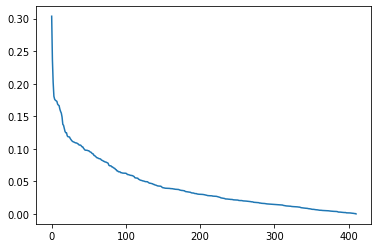

In [62]:
plt.plot(y_corr
         .sort_values(by='coefficient', ascending=False)
         .coefficient
         .to_list()
        );

In [68]:
y_corr[y_corr.coefficient >= .10].sort_values(by='coefficient', ascending=False)
y_corr_features = y_corr[y_corr.coefficient >= .10].variable.to_list()

In [69]:
y_corr_features

['EJB1_WSHMWRK',
 'TJB1_OCC',
 'TJB1_WKSUM1',
 'TJB1_MSUM',
 'TPEARN',
 'EOWN_SAV',
 'EOWN_CD',
 'EOWN_MM',
 'EOWN_MF',
 'EOWN_RP',
 'EOWN_RE',
 'EOWN_GOVS',
 'EOWN_MCBD',
 'EOWN_IRAKEO',
 'EOWN_THR401',
 'EOWN_PENSION',
 'EOWN_LIFE',
 'EOWN_ANNTR',
 'TLIFE_FVAL',
 'TPRLOANAMT',
 'TINC_BANK',
 'TVAL_BANK',
 'TVAL_OTH',
 'TVAL_RET',
 'TVAL_HOME',
 'TDEBT_HOME',
 'TVAL_VEH',
 'TEQ_VEH',
 'TDEBT_SEC',
 'THINC_BANK',
 'THVAL_BANK',
 'THVAL_OTH',
 'THVAL_RET',
 'THVAL_VEH',
 'THEQ_VEH',
 'EWHIPAYC',
 'EWMDPAY',
 'EPR_SCRNR',
 'RPRIMTH',
 'RPRITYPE1',
 'THTOTINC',
 'TFINCPOV',
 'TFCYINCPOV',
 'EEDUC_X']

In [ ]:
X_train = X_train.loc[:,y_corr_features]
X_test = X_test.loc[:,y_corr_features]

In [ ]:
# drop features with NA's - go back and impute these
X_train = X_train.drop(['ENJ_NOWRK4', 'TJB1_WKSUM1'], axis='columns')
X_test = X_test.drop(['ENJ_NOWRK4', 'TJB1_WKSUM1'], axis='columns')

In [ ]:
X_train

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
len(X_train.columns)

In [72]:
keep_cols = y_corr_features + ['EOWN_ST']
sipp_2018.loc[race_mask, keep_cols].to_csv('../data/interim/model_baseline/baseline_hispanic_blk.csv', index=True)

In [71]:
sipp_2018.loc[race_mask, keep_cols]

,EJB1_WSHMWRK,TJB1_OCC,TJB1_WKSUM1,TJB1_MSUM,TPEARN,EOWN_SAV,EOWN_CD,EOWN_MM,EOWN_MF,EOWN_RP,...,EWHIPAYC,EWMDPAY,EPR_SCRNR,RPRIMTH,RPRITYPE1,THTOTINC,TFINCPOV,TFCYINCPOV,EEDUC_X,EOWN_ST
0,2.0,9620.0,400.0,1771.0,1771.0,2,2,2,2,2,...,0,0,2,2,2,1738,1.627,1.635,5,2
2,NaN,NaN,NaN,NaN,1900.0,2,2,2,2,2,...,0,0,2,2,2,8114,3.768,3.358,6,2
4,2.0,6260.0,0.0,6250.0,6250.0,2,2,2,2,2,...,4,1,1,1,1,8114,3.768,3.358,5,2
11,2.0,2545.0,250.0,1107.0,1107.0,1,2,2,2,2,...,2,4,1,1,2,2768,2.013,2.336,9,2
12,2.0,860.0,387.0,1714.0,1714.0,2,2,2,2,2,...,0,0,1,1,2,2768,2.013,2.336,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49699,2.0,8810.0,665.0,2945.0,2945.0,1,2,2,2,1,...,1,0,2,2,2,11315,2.538,2.462,6,2
49700,2.0,4720.0,0.0,3600.0,1256.0,1,2,2,2,2,...,0,0,1,1,1,11315,2.538,2.462,7,2
49701,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,...,1,0,2,2,2,11315,2.538,2.462,9,2
49702,NaN,NaN,NaN,NaN,NaN,1,2,2,2,2,...,1,1,2,2,2,11315,2.538,2.462,5,2
